In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ATI import AboveThresholdIonization
from matplotlib.colors import LogNorm

# ATI examples
In this file we present some simple examples of how to use the ATI code to calculate photoelectron momentum distributions (PMDs), spectra and angular distrubutions for ATI.

The code has three field types implemented: Linear, circular and ellipic fields with a $\sin^2$ envelope. Examples of how to perform calculations for these fields can be found in this file. The code is made such that it should be easy for the user to implement their own fields and perform SFA calculations for those also. 

The code is intended to perform calculations using the saddle point approximation (SPA). It can also perform the all the SFA integrals numerically, which however will take quite some time.

If one wants efficient computation it is advised to provide the time integrals of the vector potential and the vector potential squared, needed to calculate the SFA action. If these are not provided they will be performed numerically through a simple numpy.trapz integration, slowing down compuation time by a bit.

## Linear field

In [28]:
settings_dict = {
    'Ip': 0.5,              # Ionization potential (a.u.)
    'Wavelength': 800,      # (nm)
    'Intensity': 1e14,      # (W/cm^2)
    'cep': np.pi/2,         # Carrier envelope phase
    'N_cycles': 2,          # Nr of cycles
    'build_in_field': 'linear',   # Build in field type to use. If using other field methods leave as a empty string ''.
    'px_start': -1.5, 'px_end': 1.5,  # Momentum bounds in x direction (a.u.)
    'py_start': 0, 'py_end': 1.,    # Momentum bounds in y direction (a.u.)
    'pz': 0.0,               # Momentum in z direction (a.u.)
    'Nx': 120, 'Ny': 60,   # Grid resolution in the x and y directions
    'N_cores': 4,           # Nr. of cores to use in the multiprocessing calculations
    'ellipticity': None,      # The ellipticity of the field. 0 is linear, 1 is circular  (only i)
    'Minimum momentum': 0.1, # Minimum abs momentum to use in the saddle point calculations for cirular field
}

In order to perform calculations, we need a first initial guess for the saddle points. The user provides these guesses, by clicking at the location of the roots of the derivative of the action, in an interactive matplotlib plot. The saddle points must be provided before calculations are performed. 

Run the code below, click at the bright spots, and close the plot window afterwards. The guesses are now saved as a member of the class.  

Each time new field settings are applied or a new instance of the ATI class is created, the saddle point guess has to be provided. An easy way to save the guesses is to use the np.save / np.load functions and manually set the guess through ATI.guess_saddle_points

In [29]:
%matplotlib qt
ATI = AboveThresholdIonization(settings_dict=settings_dict)
ATI.get_saddle_guess([0, ATI.period], [0, 80], 400, 400)

Using da linear
linear


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [30]:
ATI.guess_saddle_points

[(8.451937441847818+39.65367965367966j),
 (20.907424198255114+38.57142857142858j),
 (80.0709862911898+23.852813852813853j),
 (98.30937761307189+22.337662337662337j),
 (167.2593935860409+31.42857142857143j),
 (180.60455796790583+34.67532467532468j)]

PMD

In [31]:
%matplotlib inline
PMD = ATI.calculate_pmd_SPA()
M = np.abs(PMD)**2
M = M / np.max(M)
cmap = 'viridis'
min_val = np.max(M) * 1e-4

filter_arr = M < min_val
M[filter_arr] = min_val  # Clean up so plot looks better

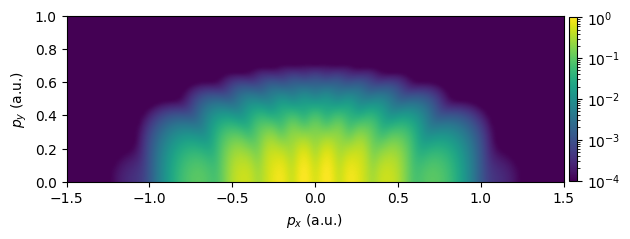

In [37]:
im = plt.imshow(np.flip(M,0), norm=LogNorm(vmax=1, vmin=min_val), aspect='equal', cmap=cmap, extent=(ATI.px_start, ATI.px_end, ATI.py_start, ATI.py_end), interpolation='bicubic')
plt.colorbar(im, fraction=0.016, pad=0.01)
plt.xlabel('$p_x$ (a.u.)')
plt.ylabel('$p_y$ (a.u.)')
plt.tight_layout()
plt.show()

ATI spectrum

In [40]:
spectrum, E_list = ATI.ATI_spectrum(energy_bounds_Up=(0.0, 3), N_points=200)

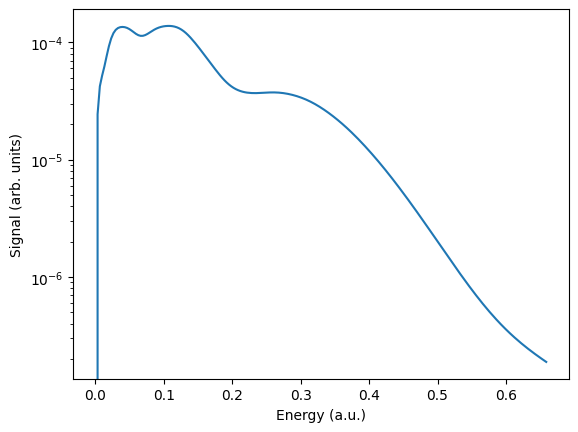

In [42]:
plt.plot(E_list, spectrum)
plt.xlabel('Energy (a.u.)')
plt.ylabel('Signal (arb. units)')
plt.yscale('log')
plt.show()

Angular distribution

In [45]:
signal, angles = ATI.ATI_angular_dist(N_phi=200, energy_bounds_Up=(0.02, 3))

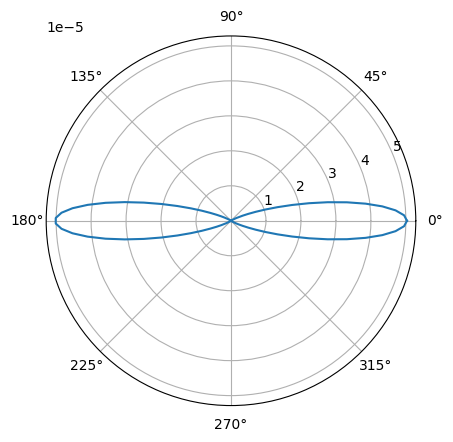

In [46]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, signal)
plt.show()

# Circular field

A circular $\sin^2$ field has $N+1$ saddle points, with $N$ beeing the number of cycles in the pulse. However, near 0 momentum two of the saddle points will be degenreate, causing the saddle point approximation to break down (i.e. results in a lot of NaN's and inf's in the code). For a circular field the ATI signal in the center is weak (almost 0), so one simple workaround (that we employ here), is to skip calculations for a small box centered at the origin of momentum space. 

The user can change the size of this box with the 'Minimum momentum' value in the settings dictionary. 

In [58]:
settings_dict = {
    'Ip': 0.5,              # Ionization potential (a.u.)
    'Wavelength': 800,      # (nm)
    'Intensity': 1e14,      # (W/cm^2)
    'cep': np.pi/2,         # Carrier envelope phase
    'N_cycles': 2,          # Nr of cycles
    'build_in_field': 'circular',   # Build in field type to use. If using other field methods leave as a empty string ''.
    'px_start': -1.5, 'px_end': 1.5,  # Momentum bounds in x direction (a.u.)
    'py_start': -1.5, 'py_end': 1.5,    # Momentum bounds in y direction (a.u.)
    'pz': 0.0,               # Momentum in z direction (a.u.)
    'Nx': 175, 'Ny': 175,   # Grid resolution in the x and y directions
    'N_cores': 4,           # Nr. of cores to use in the multiprocessing calculations
    'ellipticity': None,      # The ellipticity of the field. 0 is linear, 1 is circular  (only i)
    'Minimum momentum': 0.1, # Minimum abs momentum to use in the saddle point calculations for cirular field
}

In [59]:
%matplotlib qt
ATI = AboveThresholdIonization(settings_dict=settings_dict)
ATI.get_saddle_guess([0, ATI.period], [0, 80], 400, 400)

circular


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [60]:
%matplotlib inline
PMD = ATI.calculate_pmd_SPA()
M = np.abs(PMD)**2
M = M / np.max(M)

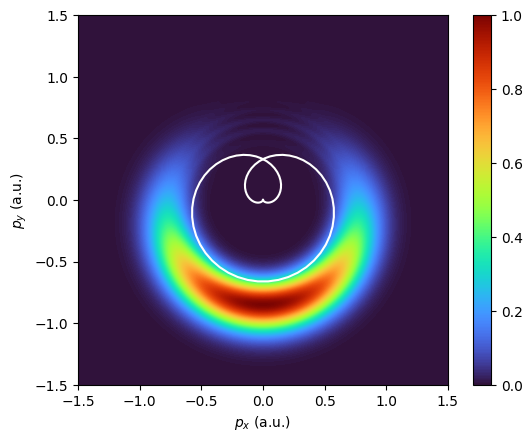

In [62]:
t_list = np.linspace(0, ATI.period, 100)
A_field = -1 * np.array([ATI.A_field(t) for t in t_list]).T  

cmap = 'turbo'
plt.imshow(np.flip(M,0), aspect='equal', cmap=cmap, extent=(ATI.px_start, ATI.px_end, ATI.py_start, ATI.py_end), interpolation='bicubic')
plt.colorbar()

plt.plot(A_field[0], A_field[1], c='w')

plt.xlabel('$p_x$ (a.u.)')
plt.ylabel('$p_y$ (a.u.)')
plt.show()